# Human Activity Recognition Tutorial with Keras and CoreML (Part 1)

## Introduction

Keras and Apple's CoreML are a very powerful toolset if you want to quickly deploy a neural network on any iOS device. Most other tutorials focus on the popular MNIST data set for image recognition. We will go beyond this widely covered machine learning example. Instead, you will learn how to process time-sliced, multi-dimensional sensor data.

To be more specific, we will train a deep neural network (DNN) to recognize the type of movement (Walking, Running, Jogging, etc.) based on a given set of accelerometer data from a mobile device carried around a person's waist. We will use the WISDM data set for this tutorial ([WISDM](http://www.cis.fordham.edu/wisdm/dataset.php)). 

The approach presented in this article should work well for any other sensor data that you might come across in the Internet of Things (IOT) area. This article walks you through the following steps:

-  Load accelerometer data from the WISDM data set
-  Convert and reformat accelerometer data into a time-sliced representation
-  Visualize the accelerometer data
-  Reshape the multi-dimensional tabular data so that it is accepted by Keras
-  Split up the data set into training, validation, and test set
-  Define a deep neural network model in Keras which can later be processed by Apple's CoreML
-  Train the deep neural network for human activity recognition data
-  Validate the performance of the trained DNN against the test data using learning curve and confusion matrix
-  Export the trained Keras DNN model for CoreML
-  Ensure that the CoreML model was exported correctly by conducting a sample prediction in Python
-  Create a playground in Xcode and import the already trained Keras model
-  Use Apple's CoreML library in order to predict the outcomes for a given data set using Swift

Prerequisites in order to conduct all steps explained in this article (including the version number that the code was tested with):

-  Python (version 3.6.5)
-  Keras (version 2.1.6)
-  TensorFlow (version 1.7.0)
-  Coremltools (version 2.0)

You might wonder why Keras was chosen for this article over other frameworks, namely tensorflow. There are two key reasons:

-  Keras is very simple to learn and has a modern, more intuitive API than tensorflow while still leveraging the capabilities of tensorflow in the backend
-  There are multiple tensorflow APIs; while trying to use the more convenient estimator API (which is also recommended by the tensorflow team - you can find more information [here](https://www.tensorflow.org/guide/estimators)) I ran into compilation issues when converting the trained estimator to CoreML

## Conceptual Overview

Before we walk through the different steps in Python and Xcode, let's take a brief look at the problem statement and our solution approach. The data set that we are using is a collection of accelerometer data taken from a smartphone that various people carried with them while conducting six different exercises (Downstairs, Jogging, Sitting, Standing, Upstairs, Walking). For each exercise the acceleration for the x, y, and z axis was measured and captured with a timestamp and person ID.

With this available data, we would like to train a neural network in order to understand if a person carrying a smartphone is performing any of the six activities. Once the neural network has been trained on this existing data, it should be able to correctly predict the type of activity a person is conducting. 

The solution to this problem is a deep neural network. Based on the available data it will learn how to differentiate between each of the six activities. We can then show new data to the neural network and it will tell us what the user is doing at any particular point in time.

## Import Libraries

First we need to import all necessary python libraries. If you are missing some of them, install them using the pip installer.

In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
# import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.
/Users/kaikaneshina/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kaikaneshina/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kaikaneshina/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kaikaneshina/anaconda3/lib/p

After importing the libraries, let's set some standard parameters and print out the Keras version that we have installed. The WISDM dataset contains six different labels (Downstairs, Jogging, Sitting, Standing, Upstairs, Walking). Since we will use the list of labels multiple times, we create a constant for them (LABELS). The next constant TIME_PERIODS stores the length of the time segment. The constant STEP_DISTANCE determines the amount of overlap between two consecutive time segments.

In [2]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  2.3.1


## Load, Inspect and Transform the Accelerometer Data

Next, you need to download the dataset form [here](http://www.cis.fordham.edu/wisdm/dataset.php) and store it locally. The important file is Data/WISDM_ar_v1.1_raw.txt. Before doing the import, let's define a few convenience functions in order to read the data and show some basic information about the data.

In [3]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [4]:
# Load data set containing all the data from csv
dataPath = '/Users/kaikaneshina/Documents/MATH178/WISDM_ar_v1.1/WISDM_ar_v1.1_raw_orig.txt'
df = read_data(dataPath)

The data is loaded into the dataframe sucessfully. Now we can display the first 20 records of the dataframe and get some more insight regarding the distribution of the data.

In [5]:
# Describe the data
show_basic_dataframe_info(df)
df.head(20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


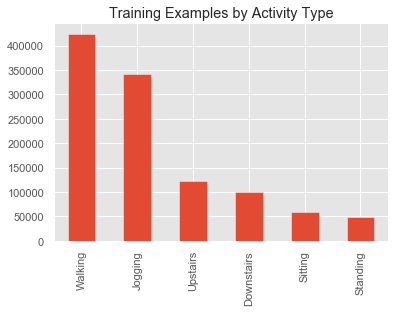

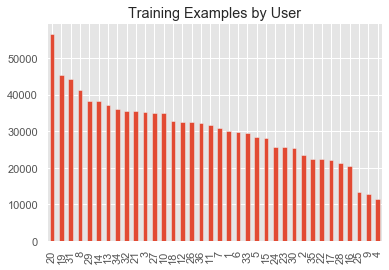

In [6]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

As we can see, we have more data for walking and jogging activities than we have for the other activities. Also we can see that 36 persons have participated in the experiment. 

Next, let's take a look at the accelerometer data for each of the three axis for all six possible activities. The data is recorded at a sampling rate of 20 Hz (20 values per second). Since we show the first 180 records, each chart shows a 9 second interval for each of the six activities (calculation: 0.05 * 180 = 9 seconds). We will use two functions (which I have borrowed from [here](http://aqibsaeed.github.io/2016-11-04-human-activity-recognition-cnn/)) to plot the data.

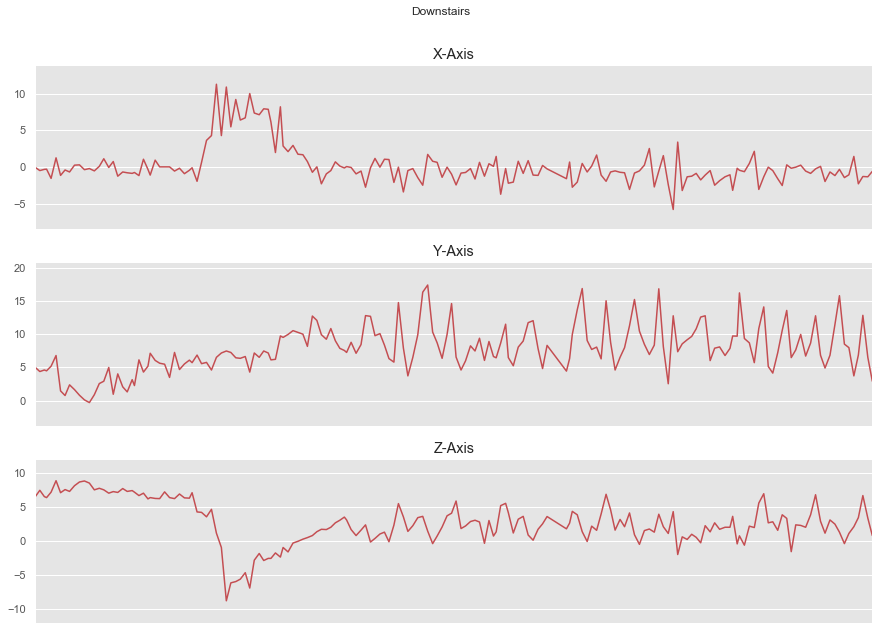

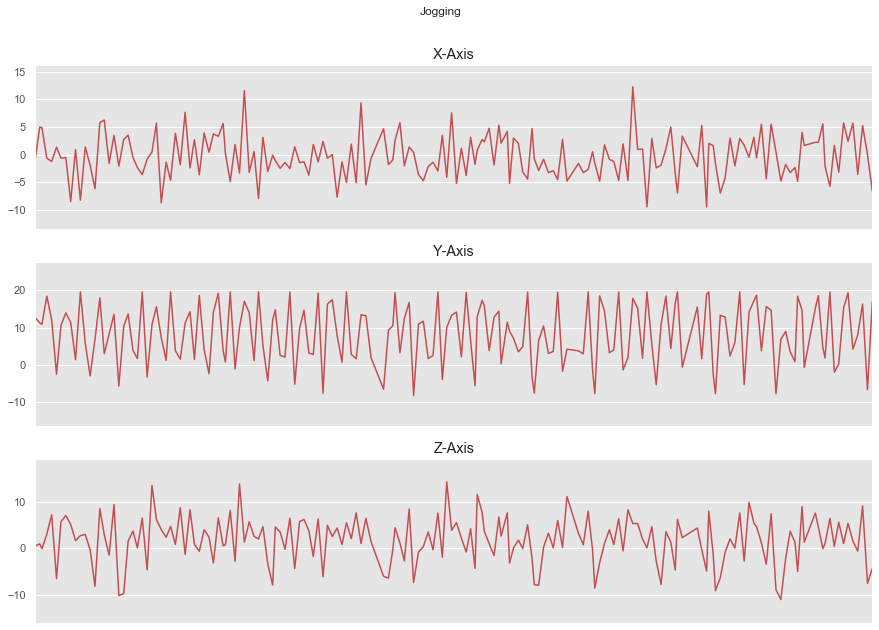

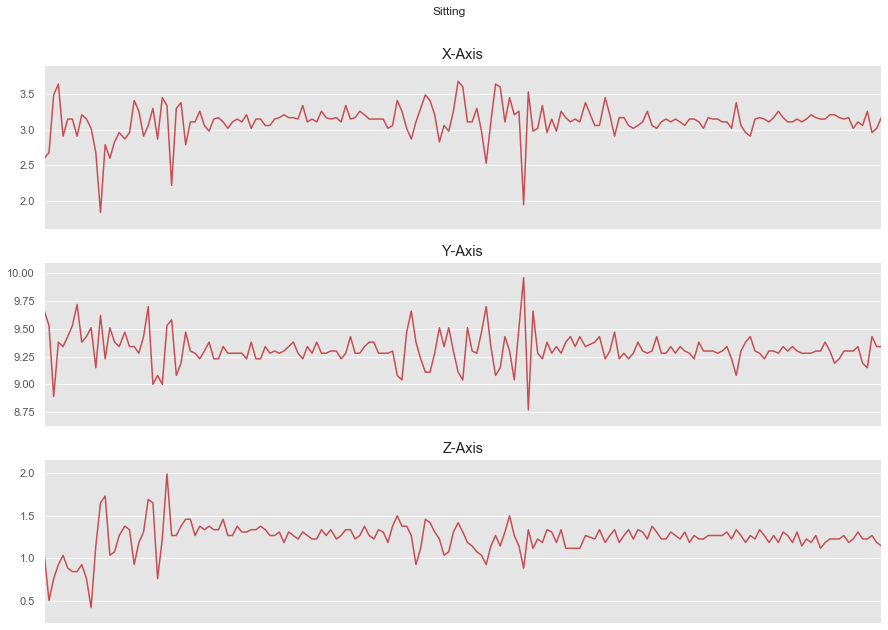

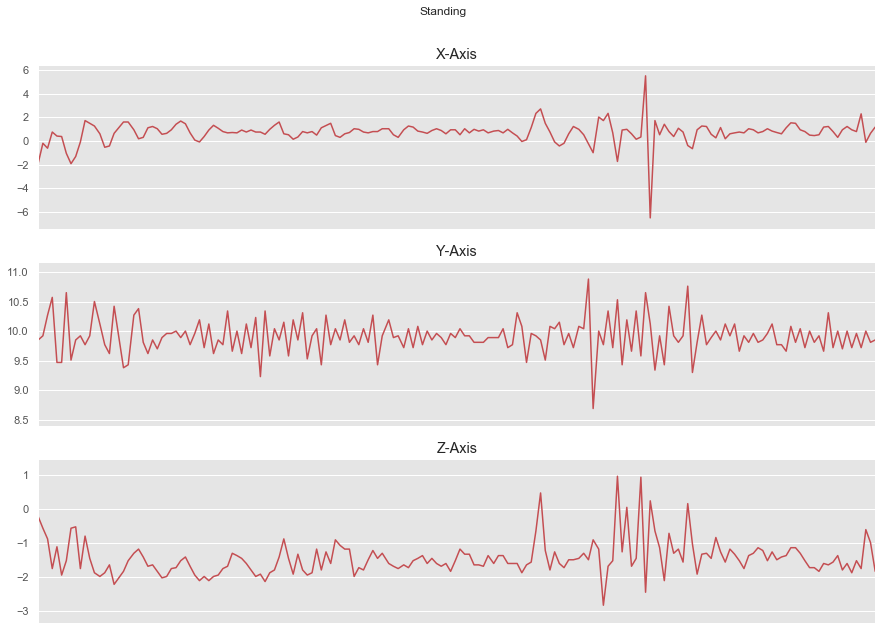

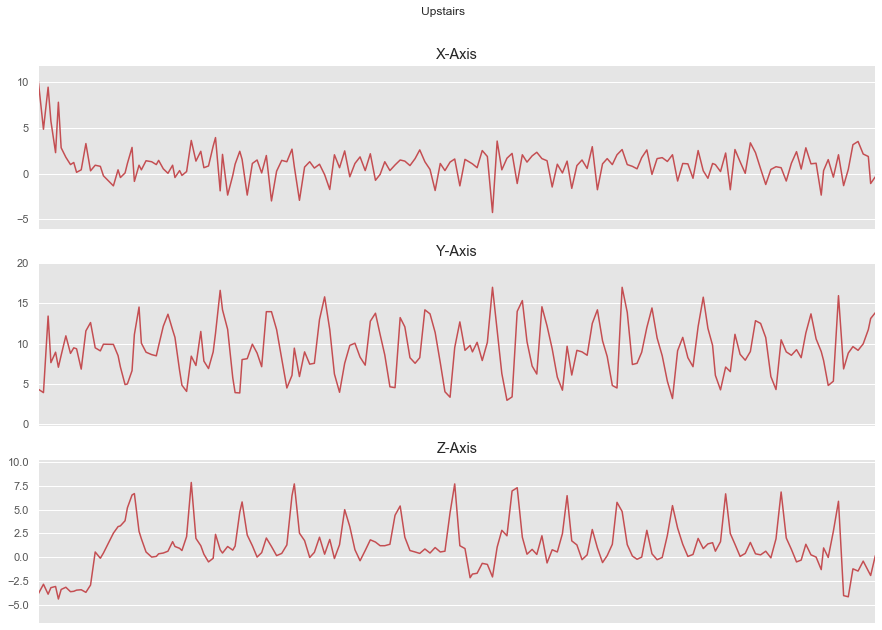

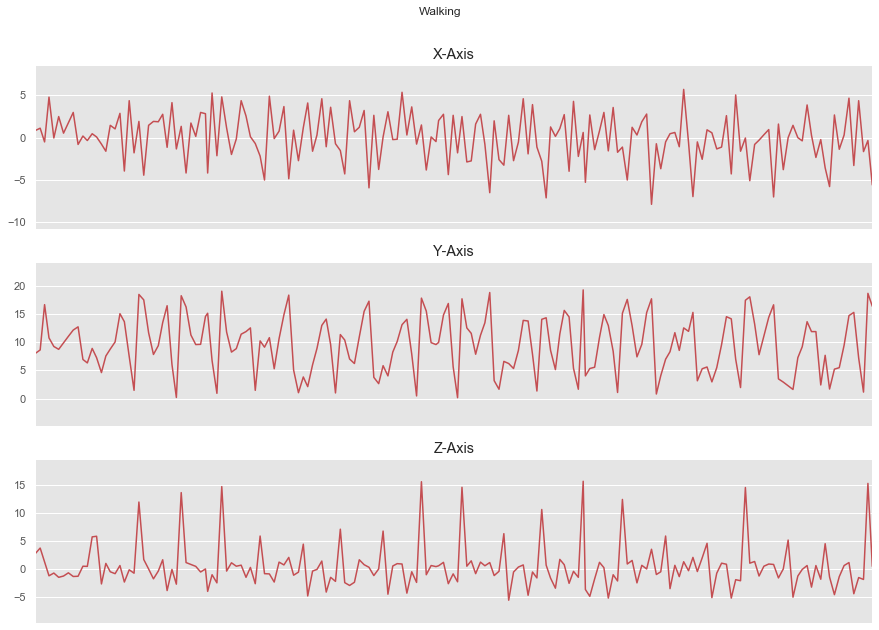

In [7]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

As expected, there is a higher acceleration for activities such as jogging and walking compared to sitting.
Before we continue, we will add one more column with the name "ActivityEncoded" to the dataframe with the encoded value for each activity:

0. Downstairs
1. Jogging
2. Sitting
3. Standing
4. Upstairs
5. Walking

This is needed since the deep neural network cannot work with non-numerical labels. With the LabelEncoder, we are able to easily to convert back to the original label text.

In [8]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

## Split Data into Training and Test Set

It is important to separate the whole data set into a training set and a test set. Often times, you see the beginner mistake on how the data is split. However you decide to split the data, you never want information from the test set to bleed into your training set. This might be great for the overall performance of your model during training and then validation against the test set. But your model is very unlikely to generalize well for data it has not seen yet. 

The idea behind splitting: We want our neural network to learn from a few persons which have been through the experiment. Next, we then want to see how well our neural network predicts the movements of persons it has not seen before. 

### Data Splitting to Avoid

Only worrying about having at least a few example records per activity is not sufficient. You will run the risk that you have maybe three records of activity "Walking" for person 5 in the training set and one record for activity "Walking" for person 5 in the test set. Of course, with this type of situation, your model will perform great because it has already seen the movement pattern of person 5 during training. Please, always be critical about the performance of your DNN - it might be because of the wrong data split in the first place. 

### Better Splitting Approach

In our case, let's split based on the user IDs. We will keep users with ID 1 to 28 for training the model and users with ID greater than 28 for the test set. This also applies for any other sensor data (e.g. Internet of Things). 

In [9]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

## Normalize Training Data

Next, we need to normalize our features within our training data. Of course there are various ways on how to normalize. Please keep in mind that you use the same normalization algorithm later when feeding new data into your neural network. Otherwise your preditions will be off. On top of the normalization I also decided to round the three features to six digits. You can play around with the optimal number here in order to further increase the performance of your network.

In [10]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

## Reshape Data into Segments and Prepare for Keras

The data contained in the dataframe is not ready yet to be fed into a neural network. Therefore we need to reshape it. Let's create another function for this called "create_segments_and_labels". This function will take in the dataframe and the label names (the constant that we have defined at the beginning) as well as the length of each record. In our case, let's go with 40 steps. Taking into consideration the 20 Hz sampling rate, this equals to 4 second time intervals (calculation: 0.05 * 80 = 4). Besides reshaping the data, the function will also separate the features (x-acceleration, y-acceleration, z-acceleration) and the labels (associated activity).

In [11]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

By now, you should have both 20.868 records in x_train as well as in y_train. Each of the 20.868 records in x_train is a two dimensional matrix of the shape 80x3. 

In [12]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


For constructing our deep neural network, we should now store the following dimensions:
-  Number of time periods: This is the number of time periods within one record (since we wanted to have a 2 second time interval, this number is 40 in our case)
-  Number of sensors: This is 3 since we only use the acceletion over the x, y, and z axis
-  Number of classes: This is the amount of nodes for our output layer in the neural network. Since we want our neural network to predict the type of activity, we will take the number of classes from the encoder that we have used earlier.

In [13]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


The data that we would like to feed into our network is 2-dimensional (80x3). Unfortunately, Keras and CoreML in conjunction are not able to process multi-dimensional input data. Therefore we need to "flatten" the data for our input layer into the neural network. Instead of feeding a matrix of shape 80x3 we will feed in a list of 240 values.

In [14]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (20868, 240)
input_shape: 240


Before continuing, we need to convert all feature data (x_train) and label data (y_train) into a datatype accepted by Keras.

In [15]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

We are almost done with the preparation of our data. One last step we need to do is to conduct one-hot-encoding of our labels. Please only execute this line once!

In [16]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20868, 6)


## Create Deep Neural Network Model in Keras

By now, you have completed all the heavy-lifting on your side. The data is ready in such a format that Keras will be able to process it. I have decided to create a neural network with 3 hidden layers of 100 fully connected nodes each (feel free to play around with the shape of the network or even switch to more complex ones like a convolutional neural network).

Important node: as you remember, we have reshaped our input data from a 40x3 matrix into a vector of length 120 so that Apple's CoreML can later process our data. In order to reverse this, our first layer in the neural network will reshape the data into the "old" format. The last two layers will again flatten the data and then run a softmax activation function in order to calculate the probability for each class. Remember, that we are working with six classes in our case (Downstairs, Jogging, Sitting, Standing, Upstairs, Walking).

In [17]:
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_2 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_3 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
__________________________________________________

## Fit the DNN Model in Keras

Next, we will fit / train the model with our training data that we have prepared earlier. We will define an early stopping callback monitor on training accuracy: if the training fails to improve for two consecutive epochs, then the training will stop with the best model. The hyperparameter used for the training are quite simple: We will use a batch size of 400 records and will train the model for 50 epochs. For model training, we will use a 80:20 split to separate training data and validation data. It is that simple. So let's go ahead and train our model. There are some good explanations out there on the different hyperparameters, for instance [here](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9).

In [18]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)


Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 9s 559us/step - loss: 1.0683 - accuracy: 0.6377 - val_loss: 0.7052 - val_accuracy: 0.8143
Epoch 2/50
16694/16694 [==============================] - 9s 527us/step - loss: 0.5862 - accuracy: 0.7879 - val_loss: 0.6284 - val_accuracy: 0.8237
Epoch 3/50
16694/16694 [==============================] - 10s 611us/step - loss: 0.5177 - accuracy: 0.8129 - val_loss: 0.6487 - val_accuracy: 0.8057
Epoch 4/50
16694/16694 [==============================] - 13s 753us/step - loss: 0.4961 - accuracy: 0.8157 - val_loss: 0.6275 - val_accuracy: 0.8299
Epoch 5/50
16694/16694 [==============================] - 11s 641us/step - loss: 0.4681 - accuracy: 0.8279 - val_loss: 0.6692 - val_accuracy: 0.8021
Epoch 6/50
16694/16694 [==============================] - 11s 641us/step - loss: 0.4596 - accuracy: 0.8292 - val_loss: 0.6411 - val_accuracy: 0.8174
Epoch 7/50
16694/16694 [==============================] - 

The performance of this simple DNN is OK. We have validation accuracy of approximately 74%. This could definitely improved - maybe with further hyperparameter tuning and especially with a modified neural network design. Before we go on with the test validation, we will print the learning curve for both the training and validation data set.

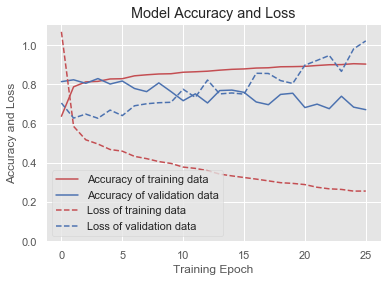

              precision    recall  f1-score   support

         0.0       0.53      0.63      0.57      1864
         1.0       0.98      0.97      0.98      6567
         2.0       0.99      0.99      0.99      1050
         3.0       0.99      0.99      0.99       833
         4.0       0.64      0.70      0.67      2342
         5.0       0.91      0.85      0.88      8212

    accuracy                           0.87     20868
   macro avg       0.84      0.86      0.85     20868
weighted avg       0.88      0.87      0.87     20868



In [19]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))


## Check Against Test Data

Let's continue with this model and see how it performs against the test data that we have held back earlier. In our case, we will check the performance against the movements of the six users that the model has not yet seen.

In [20]:
# Normalize features for training data set
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

6584/6584 [==============================] - 2s 360us/step

Accuracy on test data: 0.74

Loss on test data: 1.49


The accuracy on the test data is 76%. This means that our model generalizes well for persons it has not yet seen. Let's see where our model wrongly predicted the labels.

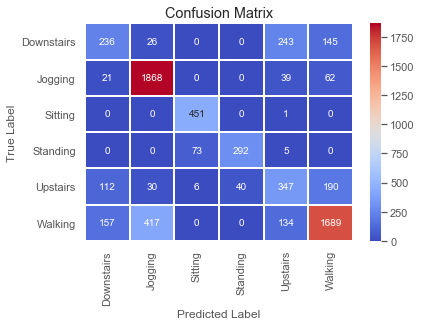

              precision    recall  f1-score   support

           0       0.45      0.36      0.40       650
           1       0.80      0.94      0.86      1990
           2       0.85      1.00      0.92       452
           3       0.88      0.79      0.83       370
           4       0.45      0.48      0.46       725
           5       0.81      0.70      0.75      2397

    accuracy                           0.74      6584
   macro avg       0.71      0.71      0.71      6584
weighted avg       0.74      0.74      0.74      6584



In [21]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

As you can see, the precision of the model is good for predicting jogging (1), sitting (2), standing (3), and walking (5). The model has problems for clearly identifying upstairs and downstairs activities. 

There is of course still great potential for improving the model, e.g. by using more advanced neural network like convolutional neural networks (CNN) or Long Short Term Memory (LSTM). I might explore this in a later article. For our purpose of showing the end to end process, the result is good enough. 

## Freeze Keras Model for CoreML

If you are happy with the model and its performance, you should convert it now to be used with CoreML. The convert function only takes in a few arguments:
-  The reference to your Keras model
-  The name that you want to give the input data; in our case we are feeding acceleration data into the network
-  The name that you want to assign to the outputs
-  The "human-readable" label names; you can again use our LABEL constant that we defined in the beginning

In [51]:
# coreml_model = coremltools.converters.keras.convert(model_m,
#                                                     input_names=['acceleration'],
#                                                     output_names=['output'],
#                                                     class_labels=LABELS)

# print(coreml_model)
# coreml_model.author = 'Nils Ackermann'
# coreml_model.license = 'N/A'
# coreml_model.short_description = 'Activity based recognition based on WISDM dataset'
# coreml_model.output_description['output'] = 'Probability of each activity'
# coreml_model.output_description['classLabel'] = 'Labels of activity'

# coreml_model.save('HARClassifier.mlmodel')

0 : reshape_2_input, <keras.engine.topology.InputLayer object at 0x1a37a9f048>
1 : reshape_2, <keras.layers.core.Reshape object at 0x1a36028208>
2 : dense_5, <keras.layers.core.Dense object at 0x1a37a9f198>
3 : dense_5__activation__, <keras.layers.core.Activation object at 0x1a337a39b0>
4 : dense_6, <keras.layers.core.Dense object at 0x1a37a9fe48>
5 : dense_6__activation__, <keras.layers.core.Activation object at 0x1a337a35c0>
6 : dense_7, <keras.layers.core.Dense object at 0x1a1f3b8c50>
7 : dense_7__activation__, <keras.layers.core.Activation object at 0x1a337a3828>
8 : flatten_2, <keras.layers.core.Flatten object at 0x1a2057bd68>
9 : dense_8, <keras.layers.core.Dense object at 0x1a251e8128>
10 : dense_8__activation__, <keras.layers.core.Activation object at 0x1a337a37f0>
input {
  name: "acceleration"
  type {
    multiArrayType {
      shape: 240
      dataType: DOUBLE
    }
  }
}
output {
  name: "output"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
outpu

## Compare Keras Prediction to CoreML Prediction

Before using your CoreML model, let's make sure that the export was successful and that both our Keras model as well as the CoreML model provide the same prediction when given a random data set. 

In [53]:
print('\nPrediction from Keras:')
test_record = x_test[1].reshape(1,input_shape)
keras_prediction = np.argmax(model_m.predict(test_record), axis=1)
print(le.inverse_transform(keras_prediction)[0])
# print('\nPrediction from Coreml:')
# coreml_prediction = coreml_model.predict({'acceleration': test_record.reshape(input_shape)})
# print(coreml_prediction["classLabel"])


Prediction from Keras:
Jogging

Prediction from Coreml:
Jogging


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Great news! For the record with index 1, both Keras and CoreML predict the same label - Jogging. We are now ready to use our CoreML model on any iOS device.

## Links and References

-  Official [Anaconda](https://www.anaconda.com) website
-  Official [Keras](https://keras.io) website
-  Official [Tensorflow](https://www.tensorflow.org) website
-  Good overview to decide which framework is for you: [Tensorflow or Keras](https://medium.com/implodinggradients/tensorflow-or-keras-which-one-should-i-learn-5dd7fa3f9ca0)
-  Good article by [Aaqib Saeed](http://aqibsaeed.github.io/2016-11-04-human-activity-recognition-cnn/) on convolutional neural networks (CNN) for human activity recognition (also using the WISDM dataset)